# Masse des peptides et la loi de Benford

In [1]:
import os
from urllib.request import urlretrieve
import gzip
import matplotlib.pyplot as plt
import numpy as np
from pyteomics import fasta, parser, mass, achrom, electrochem, auxiliary

import pybenford as ben

## Acqusition du l'archive du fichier fasta de _Saccharomyces cerevisiae_

In [2]:
if not os.path.isfile('human.fasta.gz'):
    print('Downloading the FASTA file for Saccharomyces cerevisiae...')
    try:
        urlretrieve(
            'ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/'
            'reference_proteomes/Eukaryota/UP000005640/UP000005640_9006.fasta.gz',
            'human.fasta.gz')
    except:
        print("Unable to download the file!")
    print('Done!')

## clivage des protéines du fichier fasta en petides

In [3]:
%%time
print('Cleaving the proteins with trypsin...')
unique_peptides = set()
with gzip.open('human.fasta.gz', mode='rt') as gzfile:
    for description, sequence in fasta.FASTA(gzfile):
        new_peptides = parser.cleave(sequence, 'trypsin', missed_cleavages=1)
        unique_peptides.update(new_peptides)
print('Done, {0} sequences obtained!'.format(len(unique_peptides)))

Cleaving the proteins with trypsin...
Done, 1693078 sequences obtained!
CPU times: user 3.36 s, sys: 116 ms, total: 3.48 s
Wall time: 3.48 s


In [4]:
peptides = [{'sequence': i} for i in unique_peptides]

In [5]:
%%time
print('Parsing peptide sequences...')
for peptide in peptides:
    peptide['parsed_sequence'] = parser.parse(
         peptide['sequence'],
        show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence'])
print('Done!')

Parsing peptide sequences...
Done!
CPU times: user 30.5 s, sys: 196 ms, total: 30.7 s
Wall time: 30.8 s


In [6]:
%%time
print('Calculating the mass...')
pept_not_standard_id = []
i = 0
for peptide in peptides:
    try:
        peptide['mass'] = mass.calculate_mass(peptide['parsed_sequence'])
    except:
        pept_not_standard_id.append(i)
    i += 1
print('Done!')
print(f"Number of protiens that contain non-standard amino acid : {len(pept_not_standard_id)}")

Calculating the mass...
Done!
Number of protiens that contain non-standard amino acid : 126
CPU times: user 2min 38s, sys: 64.1 ms, total: 2min 38s
Wall time: 2min 38s


In [8]:
i = 0
for id_pept in pept_not_standard_id:
    del peptides[id_pept - i]
    i += 1
len(peptides)

1692952

## Masse des peptides et la loi de Benford

In [10]:
print("Recovery of mass peptides...")
pept_mass = []
i = 0
for peptide in peptides:
    pept_mass.append(peptide['mass'])
    i += 1
print("Done!")

Recovery of mass peptides...
Done!


### Tests statistiques pour le premier digit

In [12]:
first_digit = ben.count_first_digit(pept_mass)
freq_obs = ben.normalize_first_digit(first_digit)
freq_theo = ben.get_theoretical_freq_benford()

first_digit : [650138 314951 158453  82948  77918 103545 108626 101764  94609]
freq_obs : [0.38402625 0.18603658 0.09359568 0.04899607 0.04602493 0.0611624
 0.06416366 0.06011039 0.05588404]
freq_theo : [0.30103    0.17609126 0.12493874 0.09691001 0.07918125 0.06694679
 0.05799195 0.05115252 0.04575749]


#### Histogramme de la fréquence observé et théorique

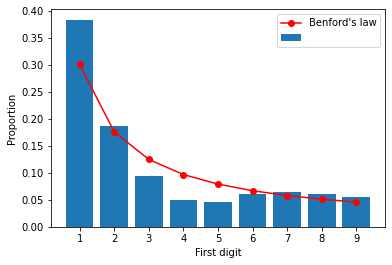

In [13]:
ben.build_hist_freq_ben(freq_obs, freq_theo, 1)

#### Test bootstrap $\chi^2$

In [14]:
%%time
ben.calculate_bootstrap_chi2(pept_mass, freq_theo, 1)

statistics : 80.62162020923584 ; p-value : 3.66481932485854e-14
CPU times: user 1min 47s, sys: 20 ms, total: 1min 47s
Wall time: 1min 47s


(80.62162020923584, 3.66481932485854e-14)

#### Test de K-S

In [15]:
%%time
ben.calculate_bootstrap_ks(pept_mass, freq_theo, 1)

Not conform to Benford law, for alpha risk = 5%

CPU times: user 1min 46s, sys: 16 ms, total: 1min 46s
Wall time: 1min 46s


(0.09472920637962214, 0.04300697617828996)

## Résultats

La masse des peptides ne suit pas la loi de Benford pour le premier digit, pour un risque alpha de 5%.

### Tests statistiques pour les 2 premiers digit

In [16]:
first_digit2 = ben.count_first_digit(pept_mass, 2)
freq_obs2 = ben.normalize_first_digit(first_digit2)
freq_theo2 = ben.get_theoretical_freq_benford(2)

first_digit : [88539 82490 76047 71150 65831 61868 57825 52815 48506 45067 42528 39770
 36934 33579 31593 29556 27992 26274 24296 22429 21308 20172 18494 17250
 15920 14971 13889 13062 12073 11314 10490  9852  8957  8718  8545  7621
  7539  7695  7089  6442  7496  7316  6410  7361  8205  7376  7357  9542
  9129  7726 10811 10750  8820 10581 11582  9760  9480 11661 10890  9210
 11607 11511  9794 10912 12047 10729  9952 11764 10974  9336 10907 10818
  9556 10062 10989 10053  9310 11135 10032  8902 10228 10035  8954  9077
 10028  9334  8789 10015  9456  8693]
freq_obs : [0.05229859 0.04872554 0.04491976 0.04202718 0.03888533 0.03654445
 0.03415631 0.03119699 0.02865173 0.02662036 0.02512062 0.02349151
 0.02181633 0.01983458 0.01866149 0.01745826 0.01653443 0.01551964
 0.01435126 0.01324846 0.0125863  0.01191528 0.01092411 0.0101893
 0.00940369 0.00884313 0.00820401 0.00771552 0.00713133 0.006683
 0.00619628 0.00581942 0.00529076 0.00514958 0.0050474  0.0045016
 0.00445317 0.00454531 0.004

#### Histogramme de la fréquence observé et théorique

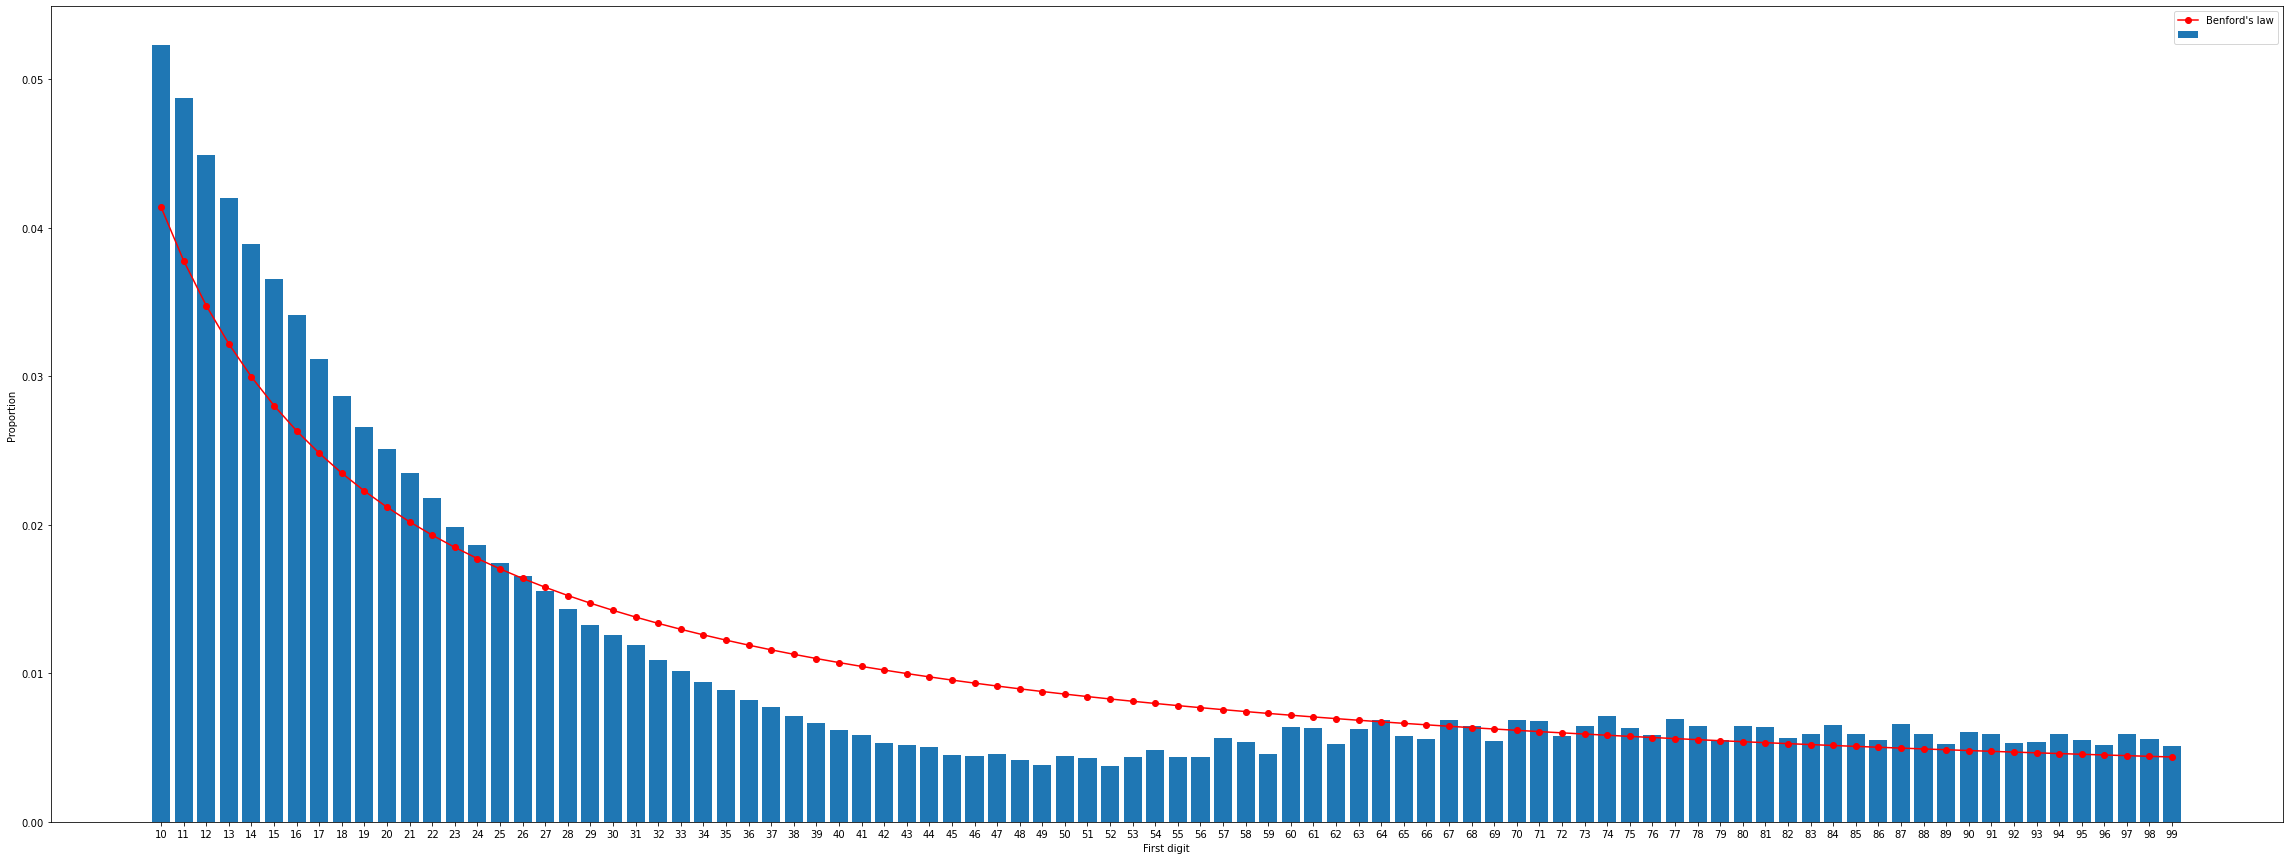

In [17]:
ben.build_hist_freq_ben(freq_obs2, freq_theo2, 2, size=(40, 15))

#### Test bootstrap $\chi^2$

In [18]:
%%time
ben.calculate_bootstrap_chi2(pept_mass, freq_theo2, 2)

statistics : 163.12130831024595 ; p-value : 2.7910215921692812e-06
CPU times: user 1min 50s, sys: 20 ms, total: 1min 50s
Wall time: 1min 50s


(163.12130831024595, 2.7910215921692812e-06)

#### Test de K-S

In [19]:
%%time
ben.calculate_bootstrap_ks(pept_mass, freq_theo2, 2)

Not conform to Benford law, for alpha risk = 5%

CPU times: user 1min 46s, sys: 20 ms, total: 1min 46s
Wall time: 1min 46s


(0.10142140942276988, 0.04300697617828996)

## Résultats

La masse des peptides ne suit pas la loi de Benford pour les 2 premiers digit, pour un risque alpha de 5%.

## Nombre de site de clivage par protéines et la loi de Benford

In [20]:
%%time
print('Cleaving the proteins with trypsin...')
num_sites = []
with gzip.open('human.fasta.gz', mode='rt') as gzfile:
    for description, sequence in fasta.FASTA(gzfile):
        num_sites.append(parser.num_sites(sequence, 'trypsin'))
print('Done, {0} sequences obtained!'.format(len(num_sites)))

Cleaving the proteins with trypsin...
Done, 20600 sequences obtained!
CPU times: user 2.37 s, sys: 4 ms, total: 2.38 s
Wall time: 2.37 s


In [21]:
print(min(num_sites))
print(max(num_sites))
print(np.mean(num_sites))

0
4209
59.16427184466019


### Premier digit

In [22]:
first_digit3 = ben.count_first_digit(num_sites)
freq_obs3 = ben.normalize_first_digit(first_digit3)

[5058 3559 2969 2393 1942 1466 1215 1096  875]
[0.24585622 0.17299373 0.14431536 0.1163175  0.09439557 0.07125845
 0.05905799 0.05327371 0.04253147]


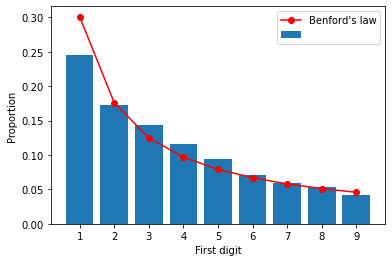

In [23]:
ben.build_hist_freq_ben(freq_obs3, freq_theo, 1)

In [24]:
ben.calculate_bootstrap_chi2(num_sites, freq_theo, 1)

statistics : 28.544541399386603 ; p-value : 0.0003810502091306308


(28.544541399386603, 0.0003810502091306308)

In [25]:
ben.calculate_bootstrap_ks(num_sites, freq_theo, 1)

Not conform to Benford law, for alpha risk = 5%



(0.061367782797514474, 0.04300697617828996)

### Deux premiers digit

In [26]:
first_digit4 = ben.count_first_digit(num_sites, 2)
freq_obs4 = ben.normalize_first_digit(first_digit4)

[810 631 525 528 421 473 391 403 409 397 397 367 423 372 323 342 329 318
 296 330 330 295 311 284 279 287 292 268 275 284 276 249 247 235 237 200
 225 235 196 204 204 172 191 198 195 196 198 184 147 171 162 144 138 139
 119 140 143 136 135 105  93 117 111  99 122 112  95  96 115  94 100  92
  99  90  86  91  93  65  82  82  81  71  68  64  72  59  58  61  73  44]
[0.04154698 0.03236561 0.0269286  0.02708248 0.02159417 0.02426139
 0.0200554  0.02067091 0.02097866 0.02036315 0.02036315 0.01882437
 0.02169676 0.01908084 0.0165675  0.01754206 0.01687526 0.01631104
 0.0151826  0.01692655 0.01692655 0.01513131 0.01595199 0.01456709
 0.01431063 0.01472097 0.01497743 0.01374641 0.01410546 0.01456709
 0.01415675 0.01277185 0.01266927 0.01205375 0.01215634 0.01025851
 0.01154083 0.01205375 0.01005334 0.01046368 0.01046368 0.00882232
 0.00979688 0.01015593 0.01000205 0.01005334 0.01015593 0.00943783
 0.00754001 0.00877103 0.0083094  0.00738613 0.00707838 0.00712967
 0.00610382 0.00718096 0.007334

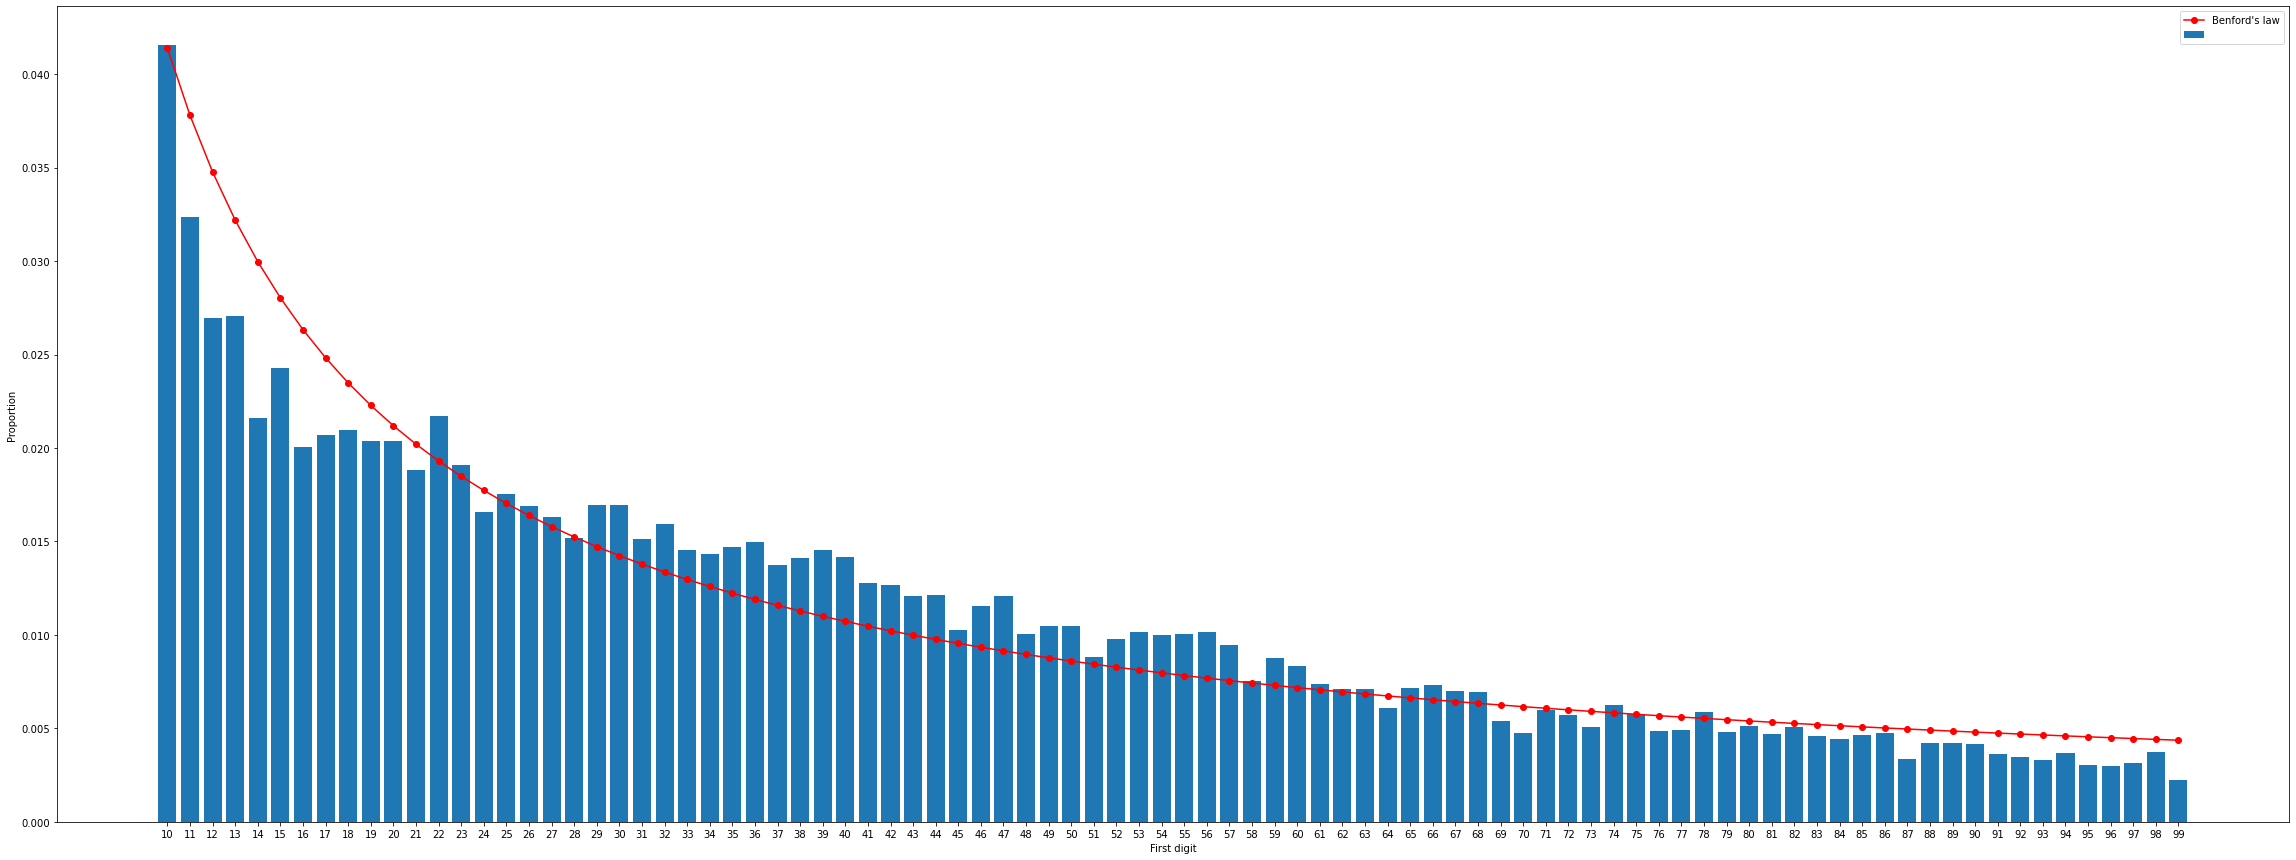

In [27]:
ben.build_hist_freq_ben(freq_obs4, freq_theo2, 2, size=(40, 15))

In [28]:
ben.calculate_bootstrap_chi2(num_sites, freq_theo2, 2)

statistics : 110.53923152270478 ; p-value : 0.06068807317667786


(110.53923152270478, 0.06068807317667786)

In [29]:
ben.calculate_bootstrap_ks(num_sites, freq_theo2, 2)

Not conform to Benford law, for alpha risk = 5%



(0.05494810360732781, 0.04300697617828996)

## Résultats

Le nombre de site de clivage par protéine ne suit pas la loi de Benford pour un rique alpha de 5%.

## Taille des peptides et la loi de Benford

In [30]:
len_pept = []
for peptide in peptides:
    len_pept.append(peptide["length"])

In [31]:
print(min(len_pept))
print(max(len_pept))
print(np.mean(len_pept))

1
2433
18.145122838686508


### Premier digit

In [32]:
first_digit5 = ben.count_first_digit(len_pept)
freq_obs5 = ben.normalize_first_digit(first_digit5)

[636459 290716 137404  76643 109897 123467 116286 104409  97671]
[0.37594628 0.17172135 0.08116237 0.04527181 0.06491442 0.07293001
 0.0686883  0.06167275 0.05769272]


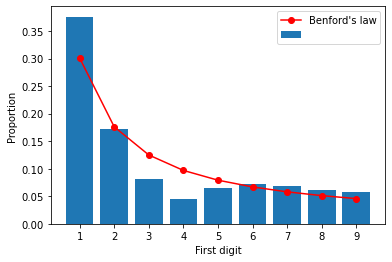

In [33]:
ben.build_hist_freq_ben(freq_obs5, freq_theo, 1)

In [34]:
ben.calculate_bootstrap_chi2(len_pept, freq_theo, 1)

statistics : 79.57916348765306 ; p-value : 5.941496824160474e-14


(79.57916348765306, 5.941496824160474e-14)

In [35]:
ben.calculate_bootstrap_ks(len_pept, freq_theo2, 2)

Not conform to Benford law, for alpha risk = 5%



(0.31584443586039135, 0.04300697617828996)

### Deux premiers digit

In [36]:
first_digit6 = ben.count_first_digit(len_pept, 2)
freq_obs6 = ben.normalize_first_digit(first_digit6)

[89311 82181 75536 71206 63484 60214 54605 49863 46854 43185 39739 36812
 33798 31595 29635 27272 25055 23786 22389 20273 19009 17353 16188 14932
 13837 12500 11958 10622  9902  8851  8451  7989  7255  6665  6004  5743
  5095  4886  4432  4112  3807  3590  3344  3110  3002  2757  2578  2487
  2215  2243  1999  1784  1702  1638  1551  1435  1354  1282  1219  1032
   997   936   855   777   800   725   667   662   635   537   554   501
   469   386   408   371   359   338   343   323   283   271   259   240
   225   208   233   194   185   165]
[0.07564805 0.06960881 0.06398038 0.06031279 0.05377211 0.05100236
 0.04625144 0.04223487 0.0396862  0.03657849 0.03365966 0.03118044
 0.02862753 0.02676154 0.02510139 0.02309988 0.02122204 0.02014718
 0.01896389 0.0171716  0.01610097 0.01469831 0.01371153 0.01264768
 0.01172019 0.01058773 0.01012865 0.00899703 0.00838718 0.00749696
 0.00715815 0.00676683 0.00614512 0.00564538 0.0050855  0.00486443
 0.00431556 0.00413853 0.00375399 0.00348294 0.00

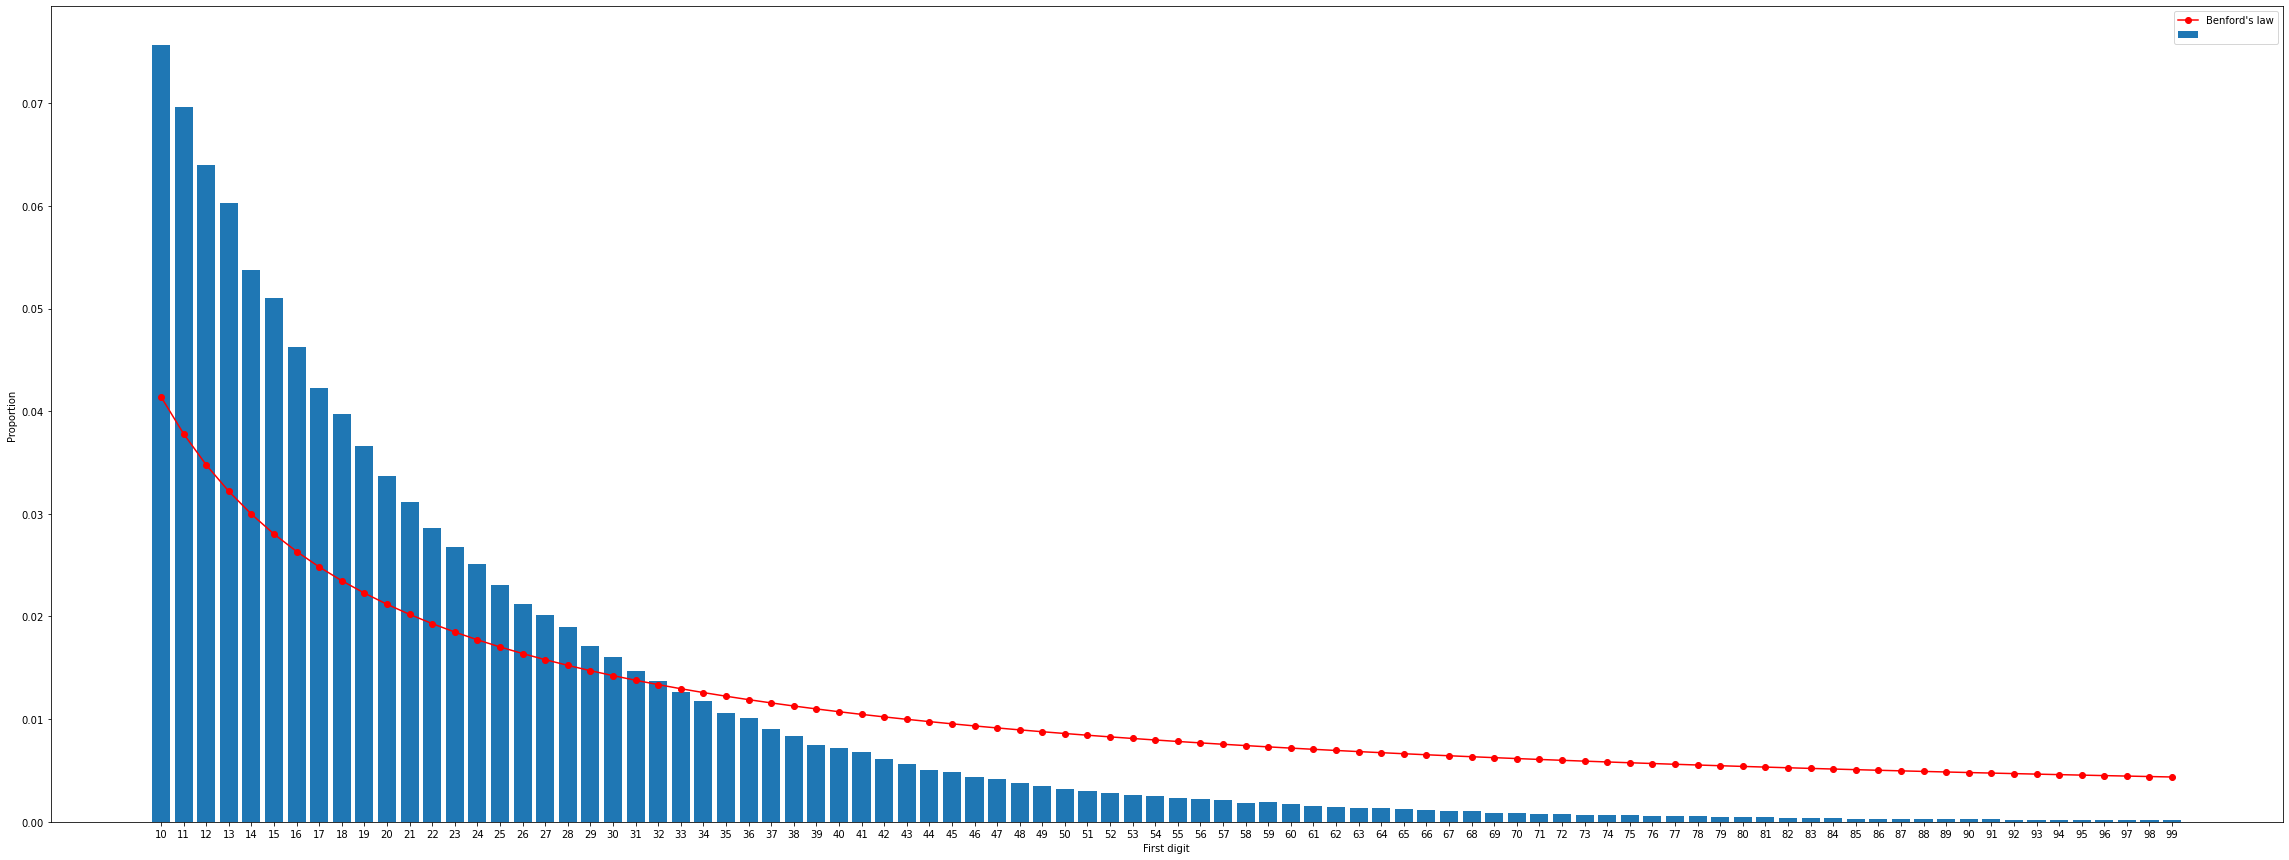

In [37]:
ben.build_hist_freq_ben(freq_obs6, freq_theo2, 2, size=(40,15))

In [38]:
ben.calculate_bootstrap_chi2(len_pept, freq_theo2, 2)

statistics : 351.51239322345356 ; p-value : 6.98979340866058e-33


(351.51239322345356, 6.98979340866058e-33)

In [39]:
ben.calculate_bootstrap_ks(len_pept, freq_theo2, 2)

Not conform to Benford law, for alpha risk = 5%



(0.3162696648609192, 0.04300697617828996)

## Résultats

La longueur des petides ne suit pas la loi de Benford pour un risque alpha de 5%.

# Conclusion

La masse et la longueur des peptides issues de la digestion par la trypsin du protéome de _Saccharomyces cerevisiae_ ne suit pas la loi de Benford pour un rsque $\alpha$ de 5%.  
De même le nombre de site de clivage par la trypsin pour les protéines du protéomes de _Saccharomyces cerevisiae_ ne suit pas la loi de Benford pour un risque $\alpha$ de 5%.